<a href="https://colab.research.google.com/github/nayana9o999/AI-Mini-project/blob/main/AIminiproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import pandas as pd
import numpy as np

def preprocess_data(input_path, output_path):
    """
    Preprocess the dataset by cleaning and normalizing fields like skills and experience.
    Args:
        input_path (str): Path to the input CSV dataset.
        output_path (str): Path to save the cleaned dataset.
    """
    # Load the dataset
    resumes_df = pd.read_csv(input_path, on_bad_lines='skip')

    # Check if 'experience' column exists, if not, skip processing it
    if 'experience' not in resumes_df.columns:
        print("Warning: 'experience' column not found. Skipping experience processing.")
    else:
        # Select relevant columns
        resumes_df = resumes_df[[
            "skills", "career_objective", "educational_institution_name",
            "degree_names", "major_field_of_studies", "experience"
        ]]

        # ... (rest of your original code for experience processing) ...


    # Drop rows with missing critical fields (outside the 'experience' check)
    resumes_df.dropna(subset=["skills", "career_objective"], inplace=True)

    # Normalize the 'skills' column
    resumes_df["skills"] = resumes_df["skills"].str.strip("[]").str.replace("'", "").str.split(", ")

    # ... (rest of your original code that doesn't depend on 'experience') ...

    # Save the cleaned dataset
    resumes_df.to_csv(output_path, index=False)
    print(f"Cleaned dataset saved to {output_path}")

# Run Preprocessing
input_file = "resume_data.csv"  # Input raw dataset
output_file = "cleaned_resumes.csv"  # Cleaned dataset
preprocess_data(input_file, output_file)

Cleaned dataset saved to cleaned_resumes.csv


In [65]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

def compute_embeddings(input_path, job_description, output_path):
    """
    Computes embeddings for candidate skills and a given job description.
    Args:
        input_path (str): Path to the cleaned CSV dataset.
        job_description (str): Job description to match candidates.
        output_path (str): Path to save the dataset with embeddings and similarity scores.
    """
    # Load the cleaned dataset
    resumes_df = pd.read_csv(input_path)

    # Load pre-trained NLP model
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Define embedding function
    def get_embedding(text):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).detach().numpy()

    # Compute job description embedding
    job_embedding = get_embedding(job_description)

    # Compute embeddings for candidate skills
    resumes_df["skills_embedding"] = resumes_df["skills"].apply(lambda x: get_embedding(" ".join(eval(x))))

    # Compute similarity scores
    resumes_df["similarity"] = resumes_df["skills_embedding"].apply(lambda x: cosine_similarity(job_embedding, x).flatten()[0])

    # Save the dataset with embeddings
    resumes_df.to_csv(output_path, index=False)
    print(f"Embeddings and similarity scores saved to {output_path}")

# Run Embedding and Similarity Calculation
input_file = "cleaned_resumes.csv"
output_file = "resumes_with_embeddings.csv"
job_desc = "Looking for a Python developer with experience in Machine Learning and NLP."
compute_embeddings(input_file, job_desc, output_file)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Embeddings and similarity scores saved to resumes_with_embeddings.csv


In [67]:
def rank_candidates(input_path, output_path, experience_weight=0.2, similarity_weight=0.7, education_bonus=0.1):
    """
    Ranks candidates based on similarity scores, experience, and education bonus.
    Args:
        input_path (str): Path to the dataset with embeddings and similarity scores.
        output_path (str): Path to save the ranked candidates.
    """
    # Load the dataset
    resumes_df = pd.read_csv(input_path)

    # Check for 'experience' column and add it if missing
    if 'experience' not in resumes_df.columns:
        resumes_df['experience'] = 0  # Add a default experience value (e.g., 0)

    # Add education bonus
    resumes_df["education_bonus"] = resumes_df["educational_institution_name"].apply(
        lambda x: education_bonus if isinstance(x, str) and ("B.Tech" in x or "M.Tech" in x) else 0
    )

    # Calculate final score
    resumes_df["final_score"] = (
        resumes_df["similarity"] * similarity_weight +
        resumes_df["experience"] * experience_weight +
        resumes_df["education_bonus"]
    )

    # Rank candidates by final score
    ranked_df = resumes_df.sort_values(by="final_score", ascending=False)

    # Save ranked candidates
    ranked_df.to_csv(output_path, index=False)
    print(f"Ranked candidates saved to {output_path}")

In [69]:
import pandas as pd
ranked_df = pd.read_csv("ranked_candidates.csv")
print(ranked_df.columns)
print(ranked_df.head())


Index(['address', 'career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results', 'result_types',
       'major_field_of_studies', 'professional_company_names', 'company_urls',
       'start_dates', 'end_dates', 'related_skils_in_job', 'positions',
       'locations', 'responsibilities', 'extra_curricular_activity_types',
       'extra_curricular_organization_names',
       'extra_curricular_organization_links', 'role_positions', 'languages',
       'proficiency_levels', 'certification_providers', 'certification_skills',
       'online_links', 'issue_dates', 'expiry_dates', '﻿job_position_name',
       'educationaL_requirements', 'experiencere_requirement',
       'age_requirement', 'responsibilities.1', 'skills_required',
       'matched_score'],
      dtype='object')
  address                                   career_objective  \
0     NaN  Big data analytics working and database wareho...   
1     NaN  Fresher looking to j

In [73]:
import pandas as pd

def rank_candidates_with_matched_score(input_path, output_path, experience_weight=0.2, similarity_weight=0.7, education_bonus=0.1):
    """
    Ranks candidates based on matched_score, experience, and education bonus.

    Args:
        input_path (str): Path to the dataset with matched scores.
        output_path (str): Path to save the ranked candidates.
    """
    try:
        # Load the dataset with error handling
        resumes_df = pd.read_csv(input_path, on_bad_lines='skip')
    except pd.errors.ParserError as e:
        print(f"Parser error: {e}")
        return

    # Check if 'experience' column exists, if not, create it and fill with 0
    if 'experience' not in resumes_df.columns:
        resumes_df['experience'] = 0

    # Calculate education bonus
    resumes_df["education_bonus"] = resumes_df["educational_institution_name"].apply(
        lambda x: education_bonus if isinstance(x, str) and ("B.Tech" in x or "M.Tech" in x) else 0
    )

    # Normalize matched_score and calculate final score
    resumes_df["final_score"] = (
        resumes_df["matched_score"] * similarity_weight +
        resumes_df["experience"].fillna(0) * experience_weight +  # Use fillna to handle potential NaNs in experience
        resumes_df["education_bonus"]
    )

    # Sort candidates by final score
    ranked_df = resumes_df.sort_values(by="final_score", ascending=False)

    # Save the ranked candidates
    ranked_df.to_csv(output_path, index=False)
    print(f"Ranked candidates saved to {output_path}")

# Run Ranking with Error Handling
input_file = "cleaned_resumes.csv"  # Change input to the cleaned dataset
output_file = "ranked_candidates.csv"  # Ranked candidates with final_score
rank_candidates_with_matched_score(input_file, output_file)

Ranked candidates saved to ranked_candidates.csv


<ipython-input-74-314bf89262a3>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_candidates, x="final_score", y=top_candidates.index, palette="viridis")


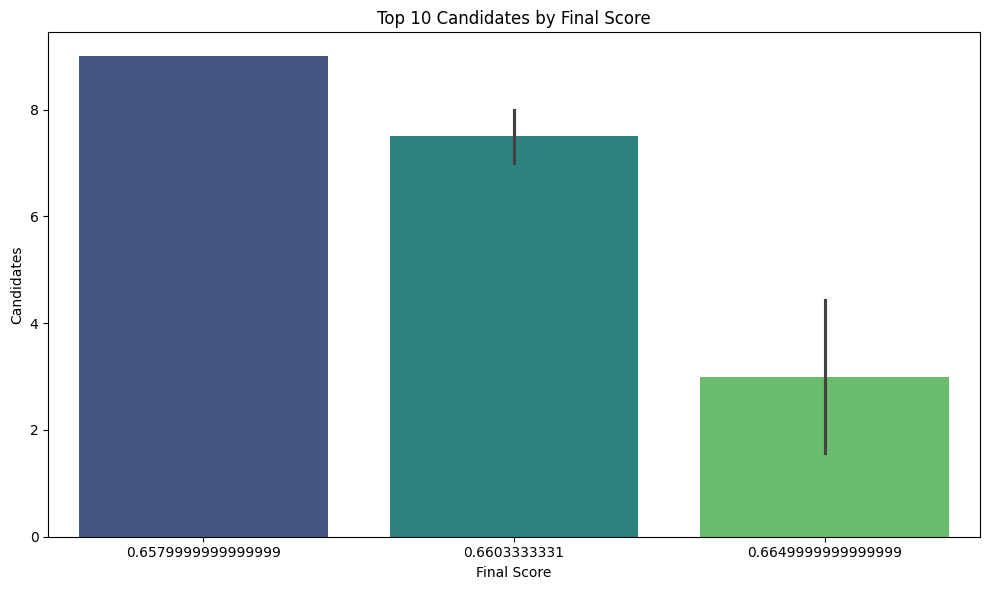

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_rankings(input_path):
    """
    Visualizes the top-ranked candidates.
    Args:
        input_path (str): Path to the ranked candidates CSV file.
    """
    # Load the ranked candidates dataset
    ranked_df = pd.read_csv(input_path)

    # Select top candidates
    top_candidates = ranked_df.head(10)

    # Plot final scores
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_candidates, x="final_score", y=top_candidates.index, palette="viridis")
    plt.title("Top 10 Candidates by Final Score")
    plt.xlabel("Final Score")
    plt.ylabel("Candidates")
    plt.tight_layout()
    plt.show()

# Run Visualization
visualize_rankings("ranked_candidates.csv")


In [77]:
import pandas as pd

def rank_candidates_with_matched_score(input_path, output_path, experience_weight=0.2, similarity_weight=0.7, education_bonus=0.1):
    """
    Ranks candidates based on matched_score, experience, and education bonus.

    Args:
        input_path (str): Path to the dataset with matched scores.
        output_path (str): Path to save the ranked candidates.
    """
    try:
        # Load the dataset with error handling
        resumes_df = pd.read_csv(input_path, on_bad_lines='skip')
    except pd.errors.ParserError as e:
        print(f"Parser error: {e}")
        return

    # Check if 'experience' column exists, if not, create it and fill with 0
    if 'experience' not in resumes_df.columns:
        resumes_df['experience'] = 0

    # Calculate education bonus
    resumes_df["education_bonus"] = resumes_df["educational_institution_name"].apply(
        lambda x: education_bonus if isinstance(x, str) and ("B.Tech" in x or "M.Tech" in x) else 0
    )

    # Normalize matched_score and calculate final score
    resumes_df["final_score"] = (
        resumes_df["matched_score"] * similarity_weight +
        resumes_df["experience"].fillna(0) * experience_weight +  # Use fillna to handle potential NaNs in experience
        resumes_df["education_bonus"]
    )

    # Sort candidates by final score
    ranked_df = resumes_df.sort_values(by="final_score", ascending=False)

    # Ensure 'similarity' and 'experience' columns are included if present in original DataFrame
    if 'similarity' in resumes_df.columns:
        ranked_df['similarity'] = resumes_df['similarity']
    if 'experience' in resumes_df.columns:
        ranked_df['experience'] = resumes_df['experience']

    # Save the ranked candidates
    ranked_df.to_csv(output_path, index=False)
    print(f"Ranked candidates saved to {output_path}")

# Run Ranking with Error Handling
input_file = "cleaned_resumes.csv"  # Change input to the cleaned dataset
output_file = "ranked_candidates.csv"  # Ranked candidates with final_score
rank_candidates_with_matched_score(input_file, output_file)

Ranked candidates saved to ranked_candidates.csv


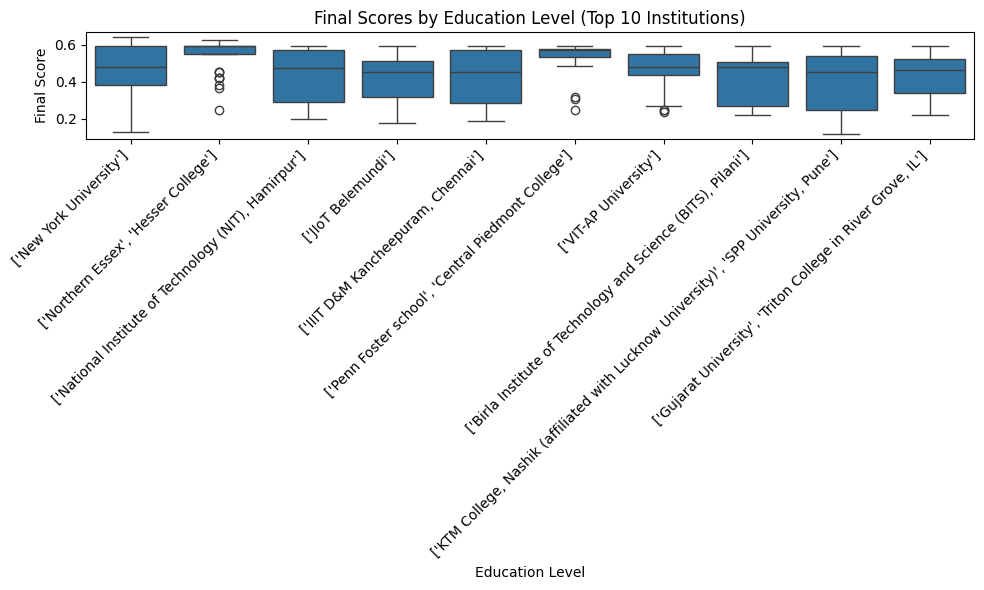

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_rankings(input_path):
    """
    Visualizes the top-ranked candidates using various plots.
    Args:
        input_path (str): Path to the ranked candidates CSV file.
    """
    # Load the ranked candidates dataset
    ranked_df = pd.read_csv(input_path)

    # ... (other visualizations remain the same) ...

    # 3. Box plot of final scores by education level (if available)
    if "educational_institution_name" in ranked_df.columns:
        plt.figure(figsize=(10, 6))

        # Limit the number of institutions displayed (e.g., top 10)
        top_institutions = ranked_df["educational_institution_name"].value_counts().head(10).index
        filtered_df = ranked_df[ranked_df["educational_institution_name"].isin(top_institutions)]

        sns.boxplot(data=filtered_df, x="educational_institution_name", y="final_score")
        plt.title("Final Scores by Education Level (Top 10 Institutions)")
        plt.xlabel("Education Level")
        plt.ylabel("Final Score")

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# Run Visualization
visualize_rankings("ranked_candidates.csv")

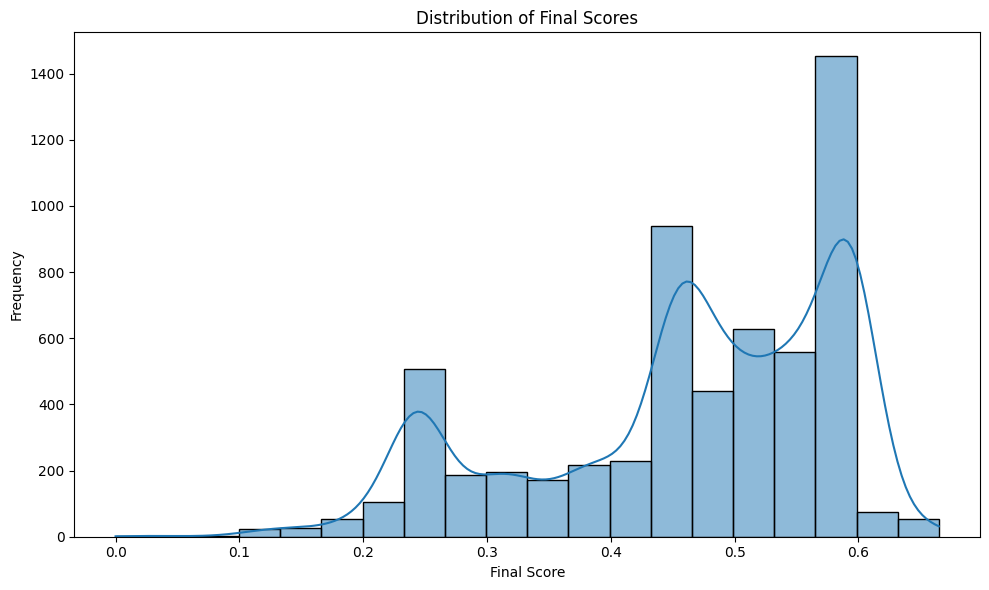

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_rankings(input_path):
    """
    Visualizes the top-ranked candidates using various plots.
    Args:
        input_path (str): Path to the ranked candidates CSV file.
    """
    # Load the ranked candidates dataset
    ranked_df = pd.read_csv(input_path)

    # ... (other visualizations remain the same) ...

    # 2. Distribution of final scores
    plt.figure(figsize=(10, 6))
    sns.histplot(ranked_df["final_score"], bins=20, kde=True)
    plt.title("Distribution of Final Scores")
    plt.xlabel("Final Score")
    plt.ylabel("Frequency")
    plt.tight_layout()

    # Save the distribution plot to a file
    plt.savefig("final_score_distribution.png")  # You can change the file name and format

    plt.show()  # Still show the plot in the notebook

    # ... (rest of the visualization code) ...

# Run Visualization
visualize_rankings("ranked_candidates.csv")